2023-11-03

BBME 520

Assignment 7 part A

Javid Jannat

In [1]:
import numpy as np 
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from matplotlib import pyplot as plt
import scipy

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)

output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype= np.short) #gives 1 for females and 0 for males

data_n = output_variable.size
sets_n = 10

input_variables = [None]*sets_n

for i in range(sets_n):

    ROIS = (i+1)*100

    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=ROIS)
    print('%i regions found in this atlas' % (len(np.unique( nib.load(yeo.maps).get_fdata().ravel())) - 1))

    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables[i] = masker.fit_transform(brain_data.gray_matter_maps)

dims = np.zeros(sets_n)
for i in range(sets_n):
    dims[i] = input_variables[i].shape[1]


C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\datasets\struct.py:850: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


100 regions found in this atlas
200 regions found in this atlas
300 regions found in this atlas
400 regions found in this atlas
500 regions found in this atlas
600 regions found in this atlas
700 regions found in this atlas
800 regions found in this atlas
900 regions found in this atlas
1000 regions found in this atlas


In [2]:
import sklearn
from sklearn import mixture

p_trainer = sklearn.linear_model.LogisticRegression(penalty='l2',C=1.0 , max_iter= 10000)

kmeans_trainers = [None]*10
gmm_trainers = [None]*10
pca_trainers = [None]*10
ica_trainers = [None]*10

for i,hyperparam in enumerate(np.arange(1,11)):
    kmeans_trainers[i] = sklearn.cluster.KMeans(hyperparam, n_init ='auto')
    gmm_trainers[i] = sklearn.mixture.GaussianMixture(hyperparam)
    pca_trainers[i] = sklearn.decomposition.PCA(hyperparam)
    ica_trainers[i] = sklearn.decomposition.FastICA(hyperparam, max_iter= 1000, tol=0.005)

decomp_names = ['Kmeans','GMM','PCA','ICA']

In [3]:
#Task 1

splits_n = 5
splitter = sklearn.model_selection.KFold(n_splits=splits_n, shuffle=False)
out = output_variable
input_data = input_variables[0]
accuracies = np.zeros((4,10))

for k in range(10):
    kmeans_inp = kmeans_trainers[k].fit_transform(input_data)
    gmm_inp = gmm_trainers[k].fit(input_data).predict_proba(input_data)
    pca_inp = pca_trainers[k].fit_transform(input_data)
    ica_inp = ica_trainers[k].fit_transform(input_data)

    inp_list = [kmeans_inp, gmm_inp, pca_inp, ica_inp]

    index_generator = splitter.split(input_data,out)
    
    for (train,test) in index_generator:
        
        for j,inp in enumerate(inp_list):

            accuracies[j,k] += p_trainer.fit(inp[train],out[train]).score(inp[test],out[test])/splits_n

accuracies*=100

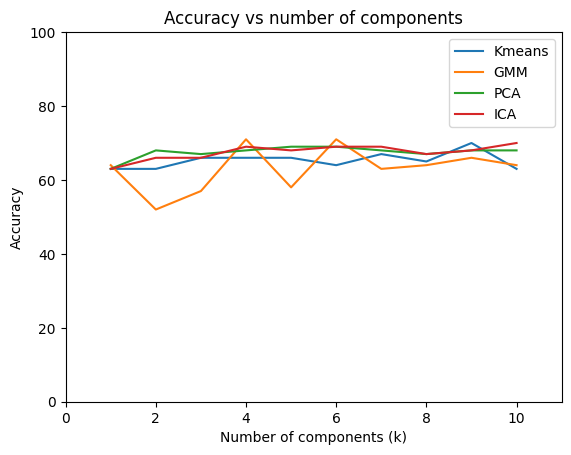

In [4]:
plt.plot(np.arange(1,11),accuracies.transpose());
plt.legend(decomp_names )
plt.ylim([0,100]);
plt.xlim([0,11]);
plt.xlabel('Number of components (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of components');

In [5]:
#Task 2

k= 5 -1 
splits_n = 5
splitter = sklearn.model_selection.KFold(n_splits=splits_n, shuffle=False)
out = output_variable
accuracies = np.zeros((4,sets_n))

for i,input_data in enumerate(input_variables):
    
    kmeans_inp = kmeans_trainers[k].fit_transform(input_data)
    gmm_inp = gmm_trainers[k].fit(input_data).predict_proba(input_data)
    pca_inp = pca_trainers[k].fit_transform(input_data)
    ica_inp = ica_trainers[k].fit_transform(input_data)

    inp_list = [kmeans_inp, gmm_inp, pca_inp, ica_inp]

    index_generator = splitter.split(input_data,out)
    
    for (train,test) in index_generator:
        
        for j,inp in enumerate(inp_list):

            accuracies[j,i] += p_trainer.fit(inp[train],out[train]).score(inp[test],out[test])/splits_n

accuracies*=100

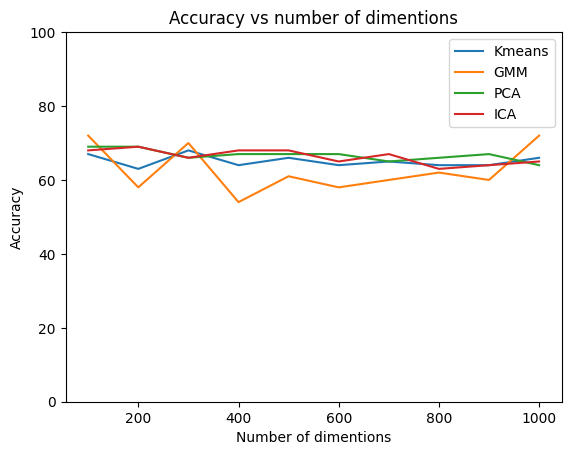

In [6]:
plt.plot(np.arange(100,1100,100),accuracies.transpose());
plt.legend(decomp_names )
plt.ylim([0,100]);

plt.xlabel('Number of dimentions')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of dimentions');

In [7]:
#Task 3

splits_n = 5
splitter = sklearn.model_selection.KFold(n_splits=splits_n, shuffle=False)
out = output_variable
input_data = input_variables[0]
outsample_accuracies = [np.zeros((10,sets_n)) for i in range (4) ]
insample_accuracies = [np.zeros((10,sets_n)) for i in range (4) ]

for i,input_data in enumerate(input_variables):

    for k in range(10):
        kmeans_inp = kmeans_trainers[k].fit_transform(input_data)
        gmm_inp = gmm_trainers[k].fit(input_data).predict_proba(input_data)
        pca_inp = pca_trainers[k].fit_transform(input_data)
        ica_inp = ica_trainers[k].fit_transform(input_data)

        inp_list = [kmeans_inp, gmm_inp, pca_inp, ica_inp]

        index_generator = splitter.split(inp,out)
        
        for (train,test) in index_generator:
            
            for j,inp in enumerate(inp_list):
                
                model = p_trainer.fit(inp[train],out[train])

                outsample_accuracies[j][k,i] += model.score(inp[test],out[test])/splits_n 
                insample_accuracies[j][k,i] +=model.score(inp[train],out[train])/splits_n 


C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\sklearn\decomp

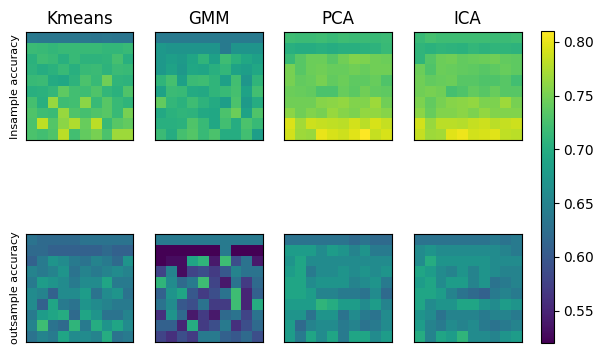

In [8]:
g_min = np.min(np.array(outsample_accuracies))
g_max = np.max(np.array(insample_accuracies))

for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(insample_accuracies[i],vmin=g_min,vmax=g_max);

    if i == 0:
        plt.ylabel('Insample accuracy',fontsize=8);

    plt.title(decomp_names[i]);
    plt.xticks([],[]);
    plt.yticks([],[]);

for i in range(4):
    plt.subplot(2,4,i+5)
    plt.imshow(outsample_accuracies[i],vmin=g_min,vmax=g_max);

    if i == 0:
            plt.ylabel('outsample accuracy',fontsize=8);

    plt.xticks([],[]);
    plt.yticks([],[]);


plt.colorbar(cax=plt.axes((0.93, 0.17, 0.02, 0.65)));

Numper of components plotted on y-axis, k=1 (top) to 10 (bottom). Number of dimentions plotted on x-axis, dims = 100 (left) to 1000 (right) in increments of 100. Accuracy denoted on colorbar to the right.

In [9]:
#Task 4

k= 10 - 1
splits_n = 5
splitter = sklearn.model_selection.KFold(n_splits=splits_n, shuffle=True)
out = output_variable
inp = input_variables[0]
coefs = [np.zeros((100,10)) for i in range (4) ]

i=0

print('Progress',end=' ')

for s in range(20):
    
    index_generator = splitter.split(inp,out)
        
    for (train,test) in index_generator:
        
        kmeans_inp = kmeans_trainers[k].fit_transform(input_data)
        gmm_inp = gmm_trainers[k].fit(input_data).predict_proba(input_data)
        pca_inp = pca_trainers[k].fit_transform(input_data)
        ica_inp = ica_trainers[k].fit_transform(input_data)

        inp_list = [kmeans_inp, gmm_inp, pca_inp, ica_inp]
        
        for j,inp in enumerate(inp_list):

            model = p_trainer.fit(inp[train],out[train])
            coefs[j][i] = model.coef_
        
        i+=1
        print(i,end=' ')



Progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 

C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

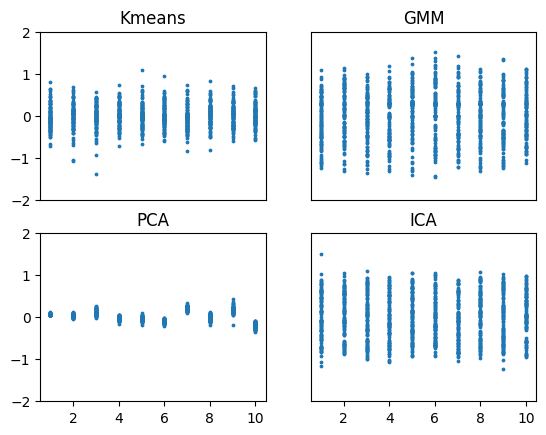

In [10]:
xvals = np.array([np.arange(1,11)]*100)
dot_size=3

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.scatter(xvals,coefs[i],dot_size)
    plt.title(decomp_names[i])
    plt.ylim([-2,2])
    if i<2:
        plt.xticks([])
    if (i%2) == 1:
        plt.yticks([])
    

Scatterplot of coefficient values obtained in regression using the four dimentionality reduction methods. Coefficients plotted on x-axis and values on y-axis.

In [11]:
#Task 5

k= 10 - 1
splits_n = 5
splitter = sklearn.model_selection.KFold(n_splits=splits_n, shuffle=True)
out = output_variable
inp = input_variables[0]
coefs = [np.zeros((100,10)) for i in range (4) ]

i=0

print('Progress',end=' ')

kmeans_inp = kmeans_trainers[k].fit_transform(input_data)
gmm_inp = gmm_trainers[k].fit(input_data).predict_proba(input_data)
pca_inp = pca_trainers[k].fit_transform(input_data)
ica_inp = ica_trainers[k].fit_transform(input_data)

for s in range(20):
    
    index_generator = splitter.split(inp,out)

    for (train,test) in index_generator:

        inp_list = [kmeans_inp, gmm_inp, pca_inp, ica_inp]
        
        for j,inp in enumerate(inp_list):

            model = p_trainer.fit(inp[train],out[train])
            coefs[j][i] = model.coef_
        
        i+=1
        print(i,end=' ')

Progress 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

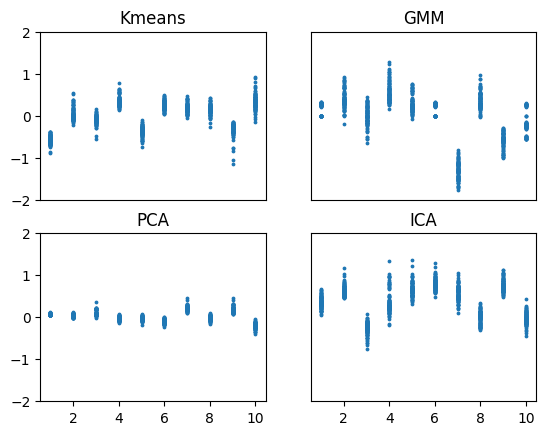

In [12]:
xvals = np.array([np.arange(1,11)]*100)
dot_size=3

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.scatter(xvals,coefs[i],dot_size)
    plt.title(decomp_names[i])
    plt.ylim([-2,2])
    if i<2:
        plt.xticks([])
    if (i%2) == 1:
        plt.yticks([])

Scatterplot of coefficient values obtained in regression using the four dimentionality reduction methods. random_state was kept constant. Coefficients plotted on x-axis and values on y-axis.